#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Описание данных

Данные находятся в файле `taxi.csv`  
Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# План Работ

- Загрузка и ознакомление с данными: 
    - загрузка данных
    - ресемплирование по одному часу
    - проверка на монотонность
- Анализ данных:
    - разложение данных на составляющие: тренд, сезонность и остаток
    - анализ тренда и сезонности
- Обучение модели и контроль качества:
    - добавление признаков к датафрейму
    - разделение данных на обучающую и тестовую выборки в соотношении 9:1
    - выделение признаков для обучения модели и целевого признака
    - обучение моделей с подбором гиперпараметров
- Проверка лучшей модели на тестовой выборке:
    - расчёт метрики RMSE для тестовой выборки
    - визуальное сравнение предсказаний и реальных значений
    - проверка адекватности модели
- Выводы

## Загрузка и ознакомление с данными

In [1]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     TimeSeriesSplit, 
                                     GridSearchCV)

In [2]:
# Откроем файл с данными и сохраним его содержимое в переменной data
# Преобразуем столбец 'datetime' в формат datetime и сделаем его индексом
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    print('Не удалось открыть файл')

# Отсортируем данные по индексу
data.sort_index(inplace=True)

# Посмотрим информацию о датафрейме
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Выполним ресемплирование по одному часу
data = data.resample('1H').sum()

# Посмотрим информацию о полученном датафрейме
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [4]:
# Проверим индексы (дату) на монотонность
data.index.is_monotonic

True

Исходные данные содержали 26496 ненулевых записей за 6 месяцев с 1 марта до 31 августа 2018 г. После ресемплирования по одному часу записей стало 4416. Индексы (дата) датафрейма монотонны.

## Анализ данных

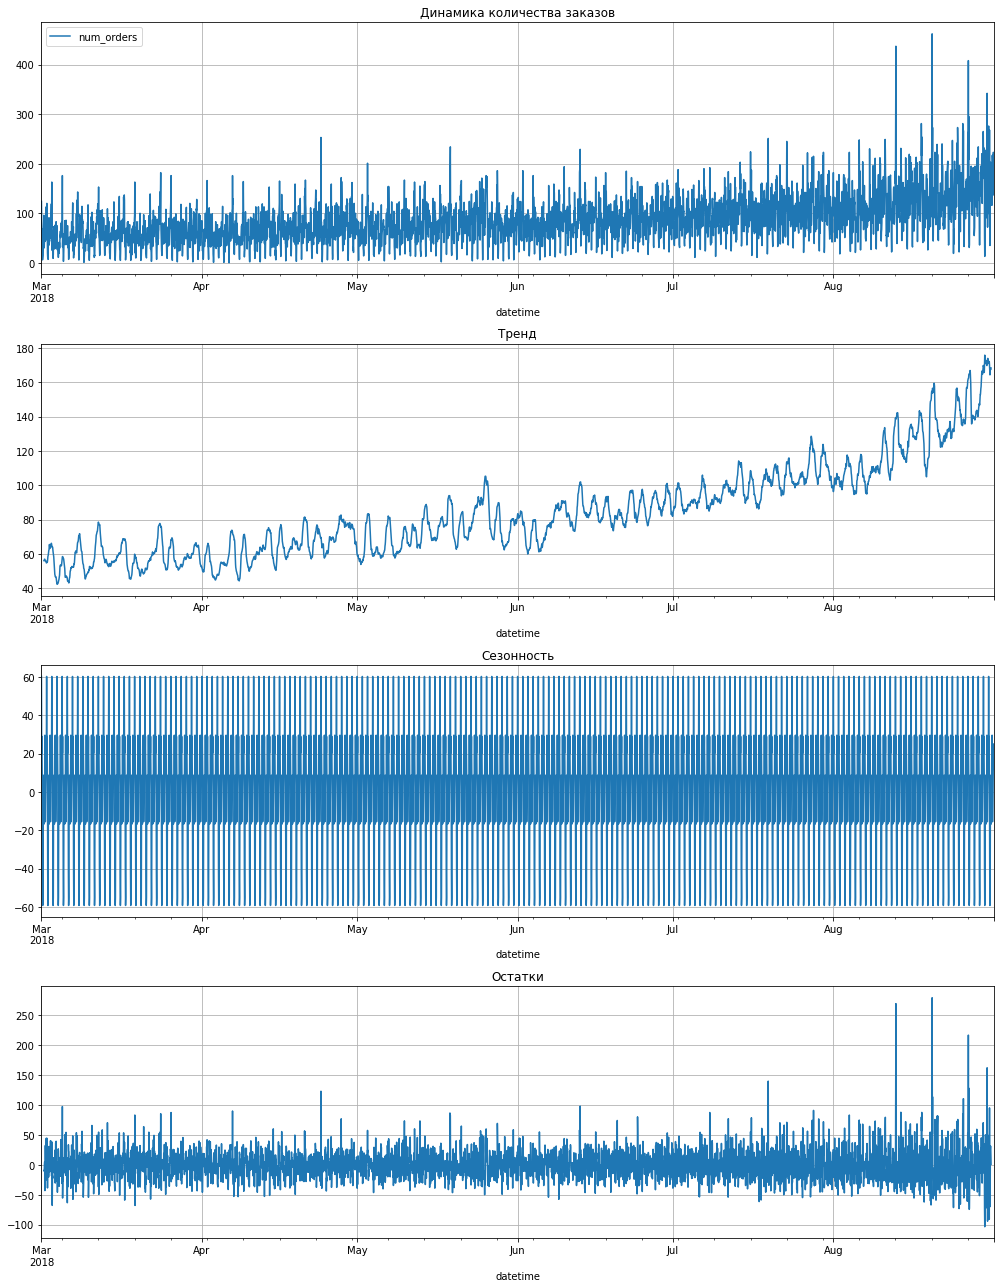

In [5]:
# Разложим временной ряд на составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(data)

# Построим графики распределения количества заказов, а так же
# графики тренда, сезонности и остатков количества заказов
plt.figure(figsize=(14, 18))

plt.subplot(411)
data.plot(ax=plt.gca(), grid=True)
plt.title('Динамика количества заказов')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Тренд')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Сезонность')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Остатки')

plt.tight_layout()

На графиках виден тренд на увеличение количества заказов за данный нам период наблюдения. Есть всплески, причины которых требуют дополнительных исследований. На графике тренда можно заметить недельные (рассмотрим подробнее) и месячные (хорошо заметна разница в начале и конце месяца) колебания количества заказов. На графике сезонности, похоже, наблюдаем суточные колебания количества заказов. Рассмотрим поближе графики тренда и сезонности.

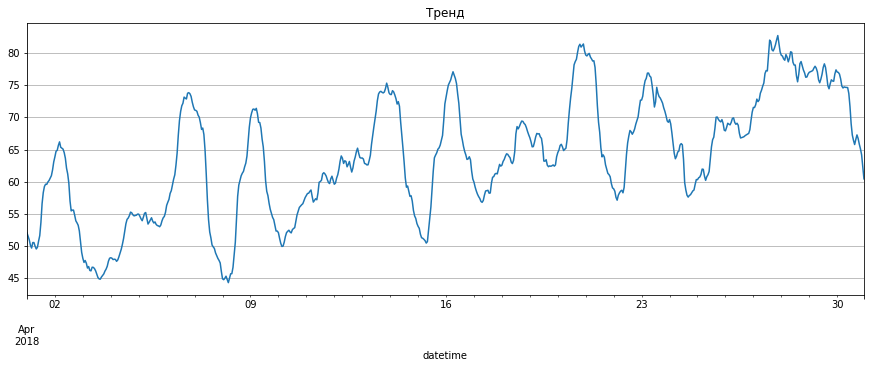

In [6]:
# Построим график трэнда за апрель в имеющемся диапазоне 
decomposed.trend['2018-04-01':'2018-04-30'].plot(ax=plt.gca(), figsize=(15, 5), grid=True)
plt.title('Тренд');

2, 9, 16, 23 и 30 апреля 2018 г. - это понедельники. Видим явное увеличение количества заказов в ночь на субботу и понедельник, и резкое снижение в ночь на воскресенье. Так же хорошо видны изменения количества заказов в течении недели с минимумов первой половины вторника.

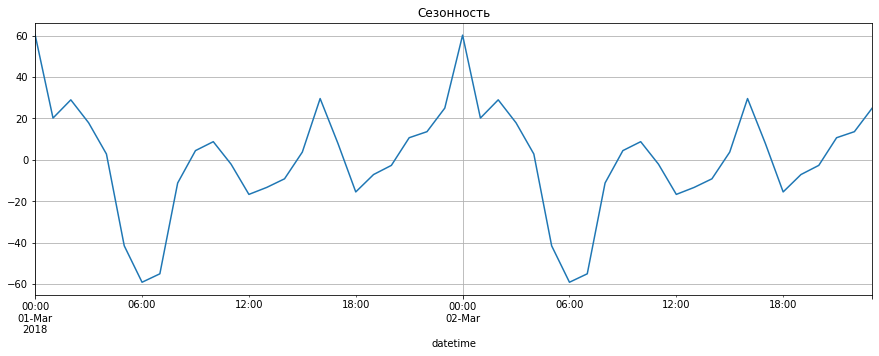

In [7]:
# Построим график сезонной составляющей за первые два дня имеющегося диапазона 
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), figsize=(15, 5), grid=True)
plt.title('Сезонность');

График сезонности показывает суточное колебание количества заказов с минимумом в 6 ч. утра и максимумом в полночь, а так же всплесками в районе 10 утра и 16 вечера.

Исследование показало зависимость количества заказов от времени суток, дня недели, дня месяца и месяца в году.

## Обучение модели и контроль качества

In [8]:
# На основании анализа напишем функцию создания признаков для нашего датафрейма
def make_features(data, max_lag, rolling_mean_size):
    # Добавим признаки дня недели и времени суток
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # Добавим признак "скользящее среднее"
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    # Добавим признаки "отстающие значения"
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [9]:
# Добавим признаки к датафрейму
make_features(data, 1, 24)

# Разделим датафрейм на обучающую и тестовую выборки в соотношении 9:1
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# Удалим пропуски, образовавшиеся в результате добавления
# признаков "скользящее среднее" и "отстающие значения"
train = train.dropna()

# Посмотрим на результат добавления и разделения
print(' Размер тренировочной выборки:', train.shape,
      '\n Размер тестовой выборки:     ', test.shape)
display(train.head())

 Размер тренировочной выборки: (3950, 5) 
 Размер тестовой выборки:      (442, 5)


,num_orders,dayofweek,hour,rolling_mean,lag_1
datetime,,,,,
2018-03-02 00:00:00,90,4,0,56.833333,58.0
2018-03-02 01:00:00,120,4,1,55.416667,90.0
2018-03-02 02:00:00,75,4,2,56.875000,120.0
2018-03-02 03:00:00,64,4,3,57.041667,75.0
2018-03-02 04:00:00,20,4,4,56.958333,64.0


Признаки добавлены корректно. Выборки разделены в соответствии с условиями.

In [10]:
# Отделим от признаков целевой 
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Для поиска гиперпараметров моделей работающих с временными рядами при разделении выборки на обучающую и валидационную применим метод TimeSeriesSplit. Значение n_splits примем равным 8, поскольку размер тестовой выборки 10% и нам необходимо сделать размер валидационной выборки примерно равным ему.

In [11]:
tscv = TimeSeriesSplit(n_splits=8)

In [12]:
# Обучим и проверим качество предсказаний модели LinearRegression
model_lr = LinearRegression()
score_lr = round(-cross_val_score(model_lr, features_train, target_train, cv=tscv,
                                  scoring='neg_root_mean_squared_error').mean(), 2)

In [13]:
# Обучим и проверим качество предсказаний модели RandomForestRegressor
param_grid_rf = {'max_depth': range(10, 16), 'n_estimators': range(200, 251, 50)}
model_rfr = GridSearchCV(RandomForestRegressor(random_state=12345, n_jobs=-1), 
                      param_grid=param_grid_rf, cv=tscv, refit=True,
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
model_rfr.fit(features_train, target_train)

print('Значения гиперпараметров:', model_rfr.best_params_)

Значения гиперпараметров: {'max_depth': 13, 'n_estimators': 200}


In [14]:
# Обучим и проверим качество предсказаний модели CatBoostRegressor
param_grid_cb = {'learning_rate': [0.03, 0.06, 0.1], 'depth': [4, 6, 10], 
                 'iterations': [20, 25, 30]}
model_cbr = GridSearchCV(CatBoostRegressor(random_state = 12345, verbose=False), 
                      param_grid=param_grid_cb, cv=tscv, refit=True,
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
model_cbr.fit(features_train, target_train)
print('Значения гиперпараметров:', model_cbr.best_params_)

Значения гиперпараметров: {'depth': 10, 'iterations': 30, 'learning_rate': 0.1}


In [15]:
# Сведём значения RMSE моделей в таблицу
pd.DataFrame({'Качество предсказания (RMSE)' : [score_lr, 
                                                round(-model_cbr.best_score_, 2),
                                                round(-model_rfr.best_score_, 2)]},
             index=['LinearRegression', 'CatBoostRegressor', 'RandomForestRegressor'])

,Качество предсказания (RMSE)
LinearRegression,31.37
CatBoostRegressor,26.16
RandomForestRegressor,24.79


Все проверенные модели показали значение метрики RMSE ниже установленного порога. Лучший результат метрики RMSE = 24.79 в нашей задаче показала модель RandomForestRegressor с гиперпараметрами max_depth'= 13, 'n_estimators'= 200. Худший результат у LinearRegression, RMSE = 31.37. Проверим модель RandomForestRegressor на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

In [16]:
# Присвоим предсказания переменной чтобы построить график не предсказывая ещё раз
predict_rfr = model_rfr.predict(features_test)  
# Посмотрим значение RMSE для тестовой выборки
print('Значение RMSE модели RandomForestRegressor для тестовой выборки: ',
      round(mean_squared_error(target_test, predict_rfr, squared=False), 2))

Значение RMSE модели RandomForestRegressor для тестовой выборки:  46.16


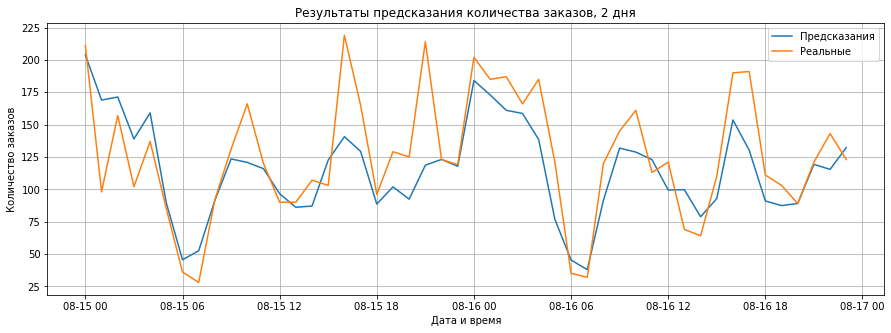

In [17]:
# Построим графики реального и предсказанного количества заказов
plt.gcf().set_size_inches(15,5)
plt.plot(pd.DataFrame(predict_rfr, 
                      index=target_test.index)['2018-08-15':
                                               '2018-08-16'], 
         label = 'Предсказания')
plt.plot(target_test['2018-08-15':'2018-08-16'], label = 'Реальные')
plt.title('Результаты предсказания количества заказов, 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid()
plt.legend()
plt.show();

Модель соответствует требованиям задачи - значение RMSE на тестовой выборке равно 46.16, что ниже установленного порога 48.  
На графике видно, что на тесте прогноз систематически ниже факта, т.е. у модели есть потенциал для улучшения.

Проверим модель на адекватность.

In [18]:
# Cравним результат с константной моделью DummyRegressor
model_dr = DummyRegressor(strategy="median")
model_dr.fit(features_train, target_train)
print('Значение RMSE константной модели DummyRegressor для тестовой выборки: ',
      round(mean_squared_error(target_test, model_dr.predict(features_test), 
                               squared=False), 2))

Значение RMSE константной модели DummyRegressor для тестовой выборки:  87.15


Качество предсказания модели DummyRegressor значительно хуже установленного порога.

# Выводы:
- Исходные данные содержали 26496 записей за период 6 месяцев с 1 марта до 31 августа 2018 г.
- Исследование показало зависимость количества заказов от времени суток, дня недели, дня месяца и месяца в году.
- В процессе обучения были проверены 3 модели: LinearRegression, CatBoostRegressor и RandomForestRegressor. Лучший результат для нашей задачи показала модель RandomForestRegressor с параметрами: max_depth'= 13, 'n_estimators'= 200.
- Проверка модели RandomForestRegressor на тестовой выборке показала результат RMSE = 46.16, удовлетворяющий требованию к точности. 